# Finding the best locations to set up an Italian Restaurant in NYC

### As my final assignment in this Capstone Project I have decided to use many concepts of data science in order to find the best areas to open up an Italian Restaurant in New York City

First and foremost, I'll begin by importing basic the libraries required

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

## Downloading the dataset 

The data containing the neighborhoods and boroughs in New York City is obtained from the dataset availabe in __NYU Spatial Data Repository__

In [48]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


### Once downloaded, Let's load the data as a list 'newyork_data'

In [49]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's display the data extracted

In [50]:
newyork_data

{'bbox': [-74.2492599487305,
  40.5033187866211,
  -73.7061614990234,
  40.9105606079102],
 'crs': {'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}, 'type': 'name'},
 'features': [{'geometry': {'coordinates': [-73.84720052054902,
     40.89470517661],
    'type': 'Point'},
   'geometry_name': 'geom',
   'id': 'nyu_2451_34572.1',
   'properties': {'annoangle': 0.0,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661],
    'borough': 'Bronx',
    'name': 'Wakefield',
    'stacked': 1},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.82993910812398, 40.87429419303012],
    'type': 'Point'},
   'geometry_name': 'geom',
   'id': 'nyu_2451_34572.2',
   'properties': {'annoangle': 0.0,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.874294193

As we can find from above, most of the data is stored in the _features_ key. So I'll set a variable that contains this key

In [51]:
neighborhoods_data = newyork_data['features']

Displaying the first item on the list

In [52]:
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

## This Data is then converted into a dataframe

In [53]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)



In [54]:
neighborhoods.head()

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

Now, let's fill the table with values using a loop to complete each row

In [55]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Displaying the dataframe again to show that the values have been sucessfully inserted

In [56]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

## Now Let's import the dataset containing the population census in New York City

The data must first be downloaded from www.catalog.data.gov website

In [57]:
population = pd.read_csv('https://data.cityofnewyork.us/api/views/swpk-hqdp/rows.csv?accessType=DOWNLOAD')

The data is downloaded and stored as a DataFrame '__population__' 

Let's take a look at the DataFrame

In [58]:
population.head()

Borough  Year  FIPS County Code NTA Code                         NTA Name  \
0   Bronx  2000                 5     BX01               Claremont-Bathgate   
1   Bronx  2000                 5     BX03  Eastchester-Edenwald-Baychester   
2   Bronx  2000                 5     BX05       Bedford Park-Fordham North   
3   Bronx  2000                 5     BX06                          Belmont   
4   Bronx  2000                 5     BX07                        Bronxdale   

   Population  
0       28149  
1       35422  
2       55329  
3       25967  
4       34309

<p>The dataframe only contains population as per 2000 and 2010, we shall only use 2010 since it gives a more accurate representstion of population density. Thus, we shall remove rows pertaining to the year '2000'</p>

In [59]:
population = population[population['Year']!=2000].reset_index(drop=True)

Now let's take a look at the dataframe

In [60]:
population.head()

Borough  Year  FIPS County Code NTA Code                         NTA Name  \
0   Bronx  2010                 5     BX01               Claremont-Bathgate   
1   Bronx  2010                 5     BX03  Eastchester-Edenwald-Baychester   
2   Bronx  2010                 5     BX05       Bedford Park-Fordham North   
3   Bronx  2010                 5     BX06                          Belmont   
4   Bronx  2010                 5     BX07                        Bronxdale   

   Population  
0       31078  
1       34517  
2       54415  
3       27378  
4       35538

<p>As you can see, the name of the column 'NTA Name' should be changed to
    'Neighborhood' in order to match the neighborhoods dataframe</p> 

In [61]:
population.columns = ['Borough','Year','FIPS Country Code','NTA Code','Neighborhood','Population']

In [62]:
population.head(1)

Borough  Year  FIPS Country Code NTA Code        Neighborhood  Population
0   Bronx  2010                  5     BX01  Claremont-Bathgate       31078

Let's drop unwanted columns from population dataframe

In [63]:
population = population.drop('Year', 1)

In [64]:
population = population.drop('FIPS Country Code', 1)

In [65]:
population = population.drop('Borough', 1)

Displaying the dataframe to see the changes made

In [66]:
population.head()

NTA Code                     Neighborhood  Population
0     BX01               Claremont-Bathgate       31078
1     BX03  Eastchester-Edenwald-Baychester       34517
2     BX05       Bedford Park-Fordham North       54415
3     BX06                          Belmont       27378
4     BX07                        Bronxdale       35538

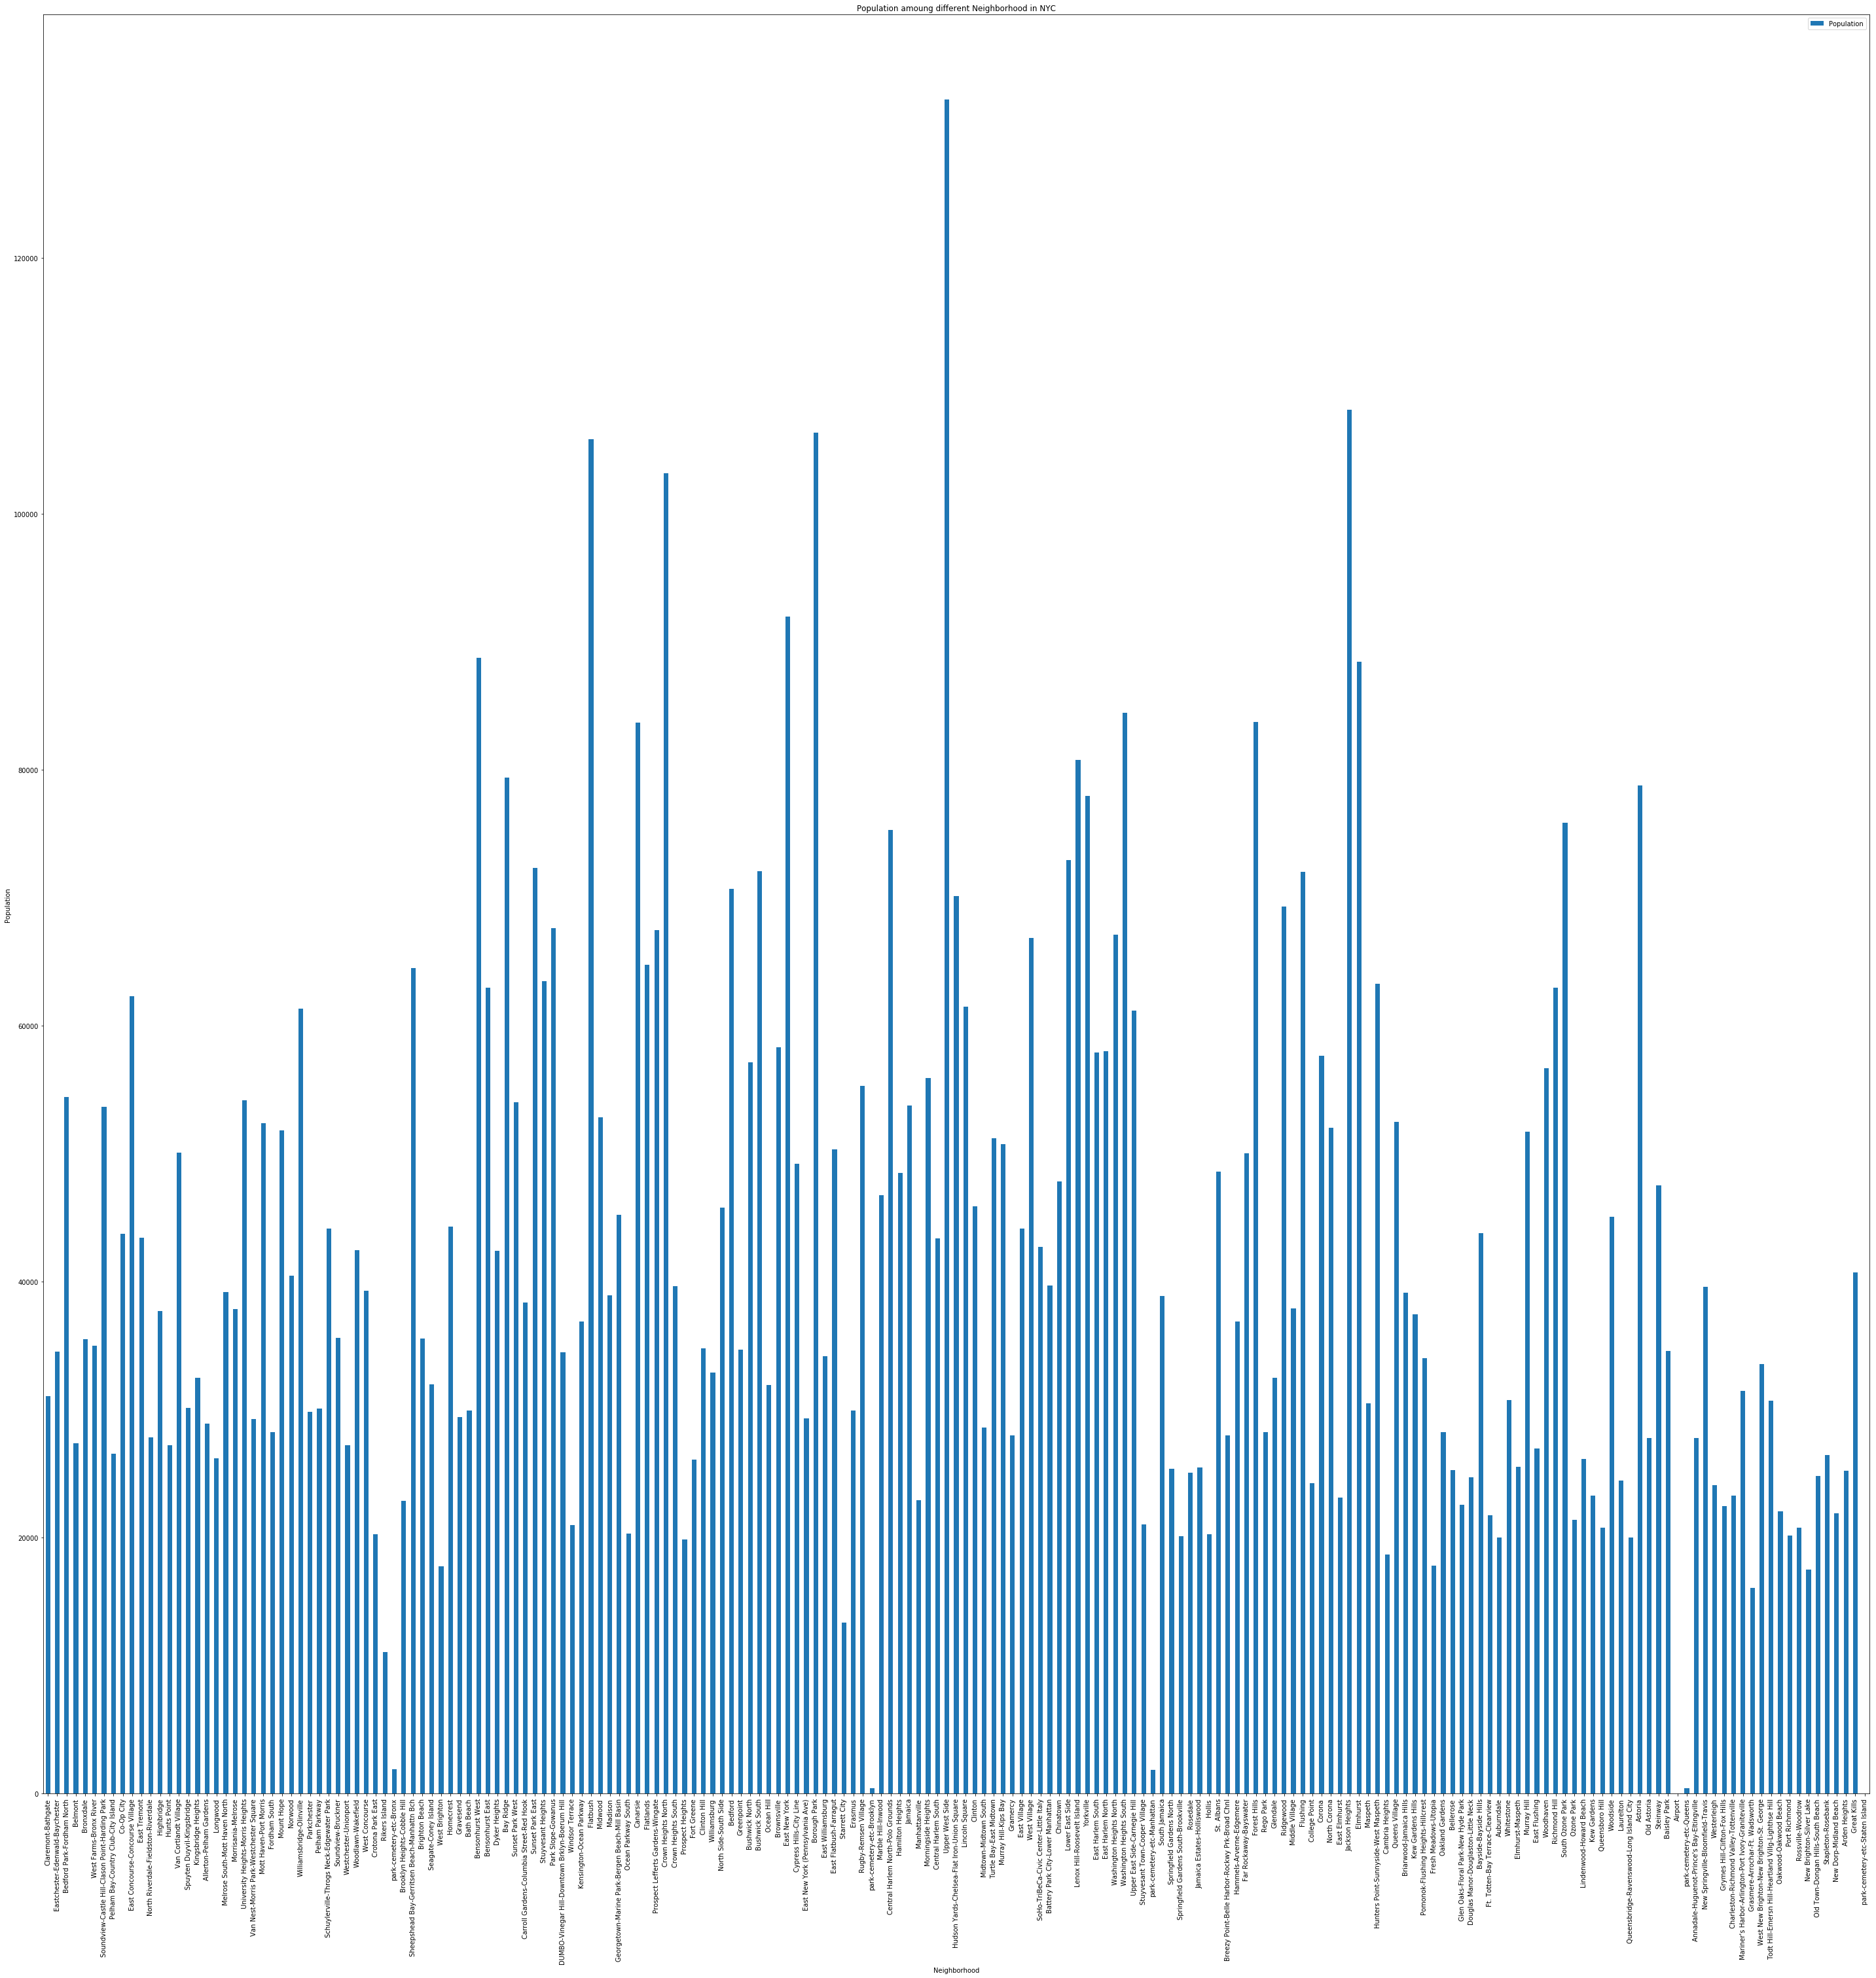

In [23]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
df_pl = population
df_pl.set_index(['Neighborhood'],inplace=True)
df_pl = df_pl.drop('NTA Code',1)
df_pl.plot(kind='bar', figsize=(50, 50))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Population amoung different Neighborhood in NYC') # add title to the plot

plt.show()

### Now lets join the two tables 

In [67]:
new_df = pd.merge(population,neighborhoods, how='inner', on = 'Neighborhood')

In [68]:
new_df.head()

NTA Code         Neighborhood  Population Borough   Latitude  Longitude
0     BX06              Belmont       27378   Bronx  40.857277 -73.888452
1     BX07            Bronxdale       35538   Bronx  40.852723 -73.861726
2     BX17         East Tremont       43423   Bronx  40.842696 -73.887356
3     BX27          Hunts Point       27204   Bronx  40.809730 -73.883315
4     BX30  Kingsbridge Heights       32496   Bronx  40.870392 -73.901523

Let's find out the average population amoung all neighborhoods

In [69]:
new_df['Population'].mean()

45215.87356321839

In [70]:
new_df['Population'].median()

37929.0

## Plotting the map of New York City with its neighbourhoods superimposed on it!

Determining the latitude and longitude of NYC and saving them to 2 variables

In [71]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [72]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Define Foursquare Credentials and Version

In [73]:
CLIENT_ID = 'YGLRVRU3XAIHB0ZTK42TTBGI2WD2GPVKE3TFZZKNSR2LWKLN' # your Foursquare ID
CLIENT_SECRET = 'ZGXCCUSPGOY2ZVP4MQWO5ACYCSVLHNWEFJWSS5BH1JLTGLM2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YGLRVRU3XAIHB0ZTK42TTBGI2WD2GPVKE3TFZZKNSR2LWKLN
CLIENT_SECRET:ZGXCCUSPGOY2ZVP4MQWO5ACYCSVLHNWEFJWSS5BH1JLTGLM2


#### Let us create a function to obatain all the venues in each neighbourhood of New York

In [74]:
limit =100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's obtain all the venues using the above created function

In [75]:
ny_venues = getNearbyVenues(names=new_df['Neighborhood'],
                                   latitudes=new_df['Latitude'],
                                   longitudes=new_df['Longitude']
                                  )

Belmont
Bronxdale
East Tremont
Hunts Point
Kingsbridge Heights
Longwood
Mount Hope
Norwood
Parkchester
Pelham Parkway
Brighton Beach
West Brighton
Homecrest
Gravesend
Bath Beach
Dyker Heights
Bay Ridge
Windsor Terrace
Flatbush
Midwood
Madison
Canarsie
Flatlands
Prospect Heights
Fort Greene
Clinton Hill
Williamsburg
Greenpoint
Ocean Hill
Brownsville
East New York
Borough Park
East Williamsburg
Starrett City
Erasmus
Hamilton Heights
Manhattanville
Morningside Heights
Upper West Side
Lincoln Square
Clinton
Gramercy
East Village
West Village
Chinatown
Lower East Side
Yorkville
South Jamaica
Rosedale
Hollis
St. Albans
Forest Hills
Rego Park
Glendale
Ridgewood
Middle Village
Flushing
College Point
Corona
North Corona
East Elmhurst
Jackson Heights
Elmhurst
Maspeth
Cambria Heights
Queens Village
Kew Gardens Hills
Oakland Gardens
Bellerose
Auburndale
Whitestone
Murray Hill
Murray Hill
Woodhaven
Richmond Hill
South Ozone Park
Ozone Park
Kew Gardens
Queensboro Hill
Woodside
Laurelton
Astoria
Stei

### Let's view the dataframe and it's size

In [76]:
print(ny_venues.shape)
ny_venues.head()

(3450, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Belmont              40.857277              -73.888452   
1      Belmont              40.857277              -73.888452   
2      Belmont              40.857277              -73.888452   
3      Belmont              40.857277              -73.888452   
4      Belmont              40.857277              -73.888452   

                   Venue  Venue Latitude  Venue Longitude      Venue Category  
0    Tino's Delicatessen       40.855882       -73.887166  Italian Restaurant  
1  Casa Della Mozzarella       40.855440       -73.887373       Deli / Bodega  
2     Full Moon Pizzeria       40.855506       -73.887557         Pizza Place  
3     Gino's Pastry Shop       40.855761       -73.887969        Dessert Shop  
4    DeLillo Pastry Shop       40.855364       -73.887198        Dessert Shop

<p>Now, we want to obtain the number of venue categories in every neighborhood in NYC.
    Thus, we use one hot encoding, and then obtain the normalized value of the count of each venue category
    belonging to a neighbourhood</p>

In [77]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

Yoga Studio  Accessories Store  American Restaurant  Antique Shop  Arcade  \
0            0                  0                    0             0       0   
1            0                  0                    0             0       0   
2            0                  0                    0             0       0   
3            0                  0                    0             0       0   
4            0                  0                    0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
0                 0                       0            0                    0   
1                 0                       0            0                    0   
2                 0                       0            0                    0   
3                 0                       0            0                    0   
4                 0                       0            0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                     0                 0                   0   
1                     0                 0                   0   
2                     0                 0                   0   
3                     0                 0                   0   
4                     0                 0                   0   

   Austrian Restaurant  Auto Workshop  Automotive Shop  BBQ Joint  Bagel Shop  \
0                    0              0                0          0           0   
1                    0              0                0          0           0   
2                    0              0                0          0           0   
3                    0              0                0          0           0   
4                    0              0                0          0           0   

   Bakery  Bank  Bar  Baseball Field  Basketball Court  Bath House  Beach  \
0       0     0    0               0                 0           0      0   
1       0     0    0               0                 0           0      0   
2       0     0    0               0                 0           0      0   
3       0     0    0               0                 0           0      0   
4       0     0    0               0                 0           0      0   

   Beer Bar  Beer Garden  Beer Store  Bike Rental / Bike Share  Bike Shop  \
0         0            0           0                         0          0   
1         0            0           0                         0          0   
2         0            0           0                         0          0   
3         0            0           0                         0          0   
4         0            0           0                         0          0   

   Bike Trail  Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0           0       0           0              0          0         0   
1           0       0           0              0          0         0   
2           0       0           0              0          0         0   
3           0       0           0              0          0         0   
4           0       0           0              0          0         0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0              0           0                     0               0        0   
1              0           0                     0               0        0   
2              0           0                     0               0        0   
3              0           0                     0               0        0   
4              0           0                     0               0        0   

   Bubble Tea Shop  Buffet  Building  Burger Joint  Burrito Place  Bus Line  \
0                0       0         0             0              0         0   
1                0       0         0             0              0         0   
2                0       0         0             0              0         0   
3

In [78]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped

Neighborhood  Yoga Studio  Accessories Store  American Restaurant  \
0         Arden Heights     0.000000           0.000000             0.000000   
1               Astoria     0.000000           0.000000             0.000000   
2            Auburndale     0.000000           0.000000             0.047619   
3            Bath Beach     0.000000           0.000000             0.000000   
4             Bay Ridge     0.000000           0.000000             0.035294   
5             Bellerose     0.000000           0.000000             0.055556   
6               Belmont     0.000000           0.000000             0.010417   
7          Borough Park     0.000000           0.000000             0.050000   
8        Brighton Beach     0.000000           0.000000             0.000000   
9             Bronxdale     0.000000           0.000000             0.000000   
10          Brownsville     0.000000           0.000000             0.000000   
11      Cambria Heights     0.000000           0.000000             0.000000   
12             Canarsie     0.000000           0.000000             0.000000   
13            Chinatown     0.000000           0.000000             0.040000   
14              Clinton     0.000000           0.000000             0.040000   
15         Clinton Hill     0.031915           0.000000             0.000000   
16        College Point     0.000000           0.000000             0.000000   
17               Corona     0.000000           0.000000             0.000000   
18        Dyker Heights     0.000000           0.000000             0.000000   
19        East Elmhurst     0.000000           0.000000             0.000000   
20        East New York     0.000000           0.000000             0.000000   
21         East Tremont     0.000000           0.000000             0.000000   
22         East Village     0.000000           0.000000             0.020000   
23    East Williamsburg     0.000000           0.000000             0.000000   
24             Elmhurst     0.000000           0.000000             0.000000   
25              Erasmus     0.041667           0.000000             0.000000   
26             Flatbush     0.000000           0.000000             0.000000   
27            Flatlands     0.000000           0.000000             0.000000   
28             Flushing     0.015385           0.000000             0.000000   
29         Forest Hills     0.051282           0.000000             0.000000   
30          Fort Greene     0.025000           0.000000             0.012500   
31             Glendale     0.000000           0.000000             0.000000   
32             Gramercy     0.010000           0.000000             0.040000   
33            Gravesend     0.000000           0.000000             0.000000   
34          Great Kills     0.000000           0.000000             0.000000   
35           Greenpoint     0.030000           0.000000             0.010000   
36     Hamilton Heights     0.032258           0.000000             0.000000   
37               Hollis     0.000000           0.000000             0.000000   
38            Homecrest     0.000000           0.000000             0.024390   
39          Hunts Point     0.000000           0.000000             0.000000   
40      Jackson Heights     0.000000           0.000000             0.012500   
41          Kew Gardens     0.000000           0.000000             0.021277   
42    Kew Gardens Hills     0.000000           0.000000             0.000000   
43  Kingsbridge Heights     0.000000           0.000000             0.000000   
44            Laurelton     0.000000           0.000000             0.000000   
45       Lincoln Square     0.010000           0.000000             0.020000   
46             Longwood     0.000000           0.000000             0.000000   
47      Lower East Side     0.016667           0.000000             0.000000   
48              Madison     0.000000           0.000000             0.000000   
49       Ma

Merging both dataframes

In [79]:
dff = pd.merge(ny_grouped,new_df, on='Neighborhood')

In [80]:
dff

Neighborhood  Yoga Studio  Accessories Store  American Restaurant  \
0         Arden Heights     0.000000           0.000000             0.000000   
1               Astoria     0.000000           0.000000             0.000000   
2            Auburndale     0.000000           0.000000             0.047619   
3            Bath Beach     0.000000           0.000000             0.000000   
4             Bay Ridge     0.000000           0.000000             0.035294   
5             Bellerose     0.000000           0.000000             0.055556   
6               Belmont     0.000000           0.000000             0.010417   
7          Borough Park     0.000000           0.000000             0.050000   
8        Brighton Beach     0.000000           0.000000             0.000000   
9             Bronxdale     0.000000           0.000000             0.000000   
10          Brownsville     0.000000           0.000000             0.000000   
11      Cambria Heights     0.000000           0.000000             0.000000   
12             Canarsie     0.000000           0.000000             0.000000   
13            Chinatown     0.000000           0.000000             0.040000   
14              Clinton     0.000000           0.000000             0.040000   
15         Clinton Hill     0.031915           0.000000             0.000000   
16        College Point     0.000000           0.000000             0.000000   
17               Corona     0.000000           0.000000             0.000000   
18        Dyker Heights     0.000000           0.000000             0.000000   
19        East Elmhurst     0.000000           0.000000             0.000000   
20        East New York     0.000000           0.000000             0.000000   
21         East Tremont     0.000000           0.000000             0.000000   
22         East Village     0.000000           0.000000             0.020000   
23    East Williamsburg     0.000000           0.000000             0.000000   
24             Elmhurst     0.000000           0.000000             0.000000   
25              Erasmus     0.041667           0.000000             0.000000   
26             Flatbush     0.000000           0.000000             0.000000   
27            Flatlands     0.000000           0.000000             0.000000   
28             Flushing     0.015385           0.000000             0.000000   
29         Forest Hills     0.051282           0.000000             0.000000   
30          Fort Greene     0.025000           0.000000             0.012500   
31             Glendale     0.000000           0.000000             0.000000   
32             Gramercy     0.010000           0.000000             0.040000   
33            Gravesend     0.000000           0.000000             0.000000   
34          Great Kills     0.000000           0.000000             0.000000   
35           Greenpoint     0.030000           0.000000             0.010000   
36     Hamilton Heights     0.032258           0.000000             0.000000   
37               Hollis     0.000000           0.000000             0.000000   
38            Homecrest     0.000000           0.000000             0.024390   
39          Hunts Point     0.000000           0.000000             0.000000   
40      Jackson Heights     0.000000           0.000000             0.012500   
41          Kew Gardens     0.000000           0.000000             0.021277   
42    Kew Gardens Hills     0.000000           0.000000             0.000000   
43  Kingsbridge Heights     0.000000           0.000000             0.000000   
44            Laurelton     0.000000           0.000000             0.000000   
45       Lincoln Square     0.010000           0.000000             0.020000   
46             Longwood     0.000000           0.000000             0.000000   
47      Lower East Side     0.016667           0.000000             0.000000   
48              Madison     0.000000           0.000000             0.000000   
49       Ma

## Now, let's plot a choropleth map based our dataframe

First, we need to download the GeoJSON file that consists information about the coordinates of the boundaries of NYC and its boroughs

In [81]:
# download countries geojson file
!wget --quiet http://data.beta.nyc//dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson -O world_countries.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


Once the GeoJSON file is downloaded, we read the file and store it into a variable namely, world_geo

In [82]:
world_geo = r'world_countries.json' # geojson file

# create a plain world map
ny_map = folium.Map(location=[latitude, longitude], zoom_start=12)

### Let's analyze the population density in NYC with the help of a choropleth map

In [83]:
# let Folium determine the scale.
world_map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Mapbox Bright')
world_map.choropleth(
    geo_data=world_geo,
    data=dff,
    columns=['Neighborhood','Population'],
    key_on='feature.properties.neighborhood',
    
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population Density',
    reset=True
)

world_map

We can observe that majarity of neighborhoods have population of approx. 33,000. Moreover, we can also see that neighbourhoods with population greater than 50,000 can be considered heavily populated.

### Now, lets superimpose Ideal loactions for opening Italian Restaurants by adding markers to areas where there is high population density but less number of already established Italian Restaurants

Since we normalized the number of Italian Restaurants column, we'll consider values less 0.5 as less competing Italian Restaurants.

In [84]:
world_geo = r'world_countries.json'


# let Folium determine the scale.
world_map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Mapbox Bright')
world_map.choropleth(
    geo_data=world_geo,
    data=dff,
    columns=['Neighborhood','Population'],
    key_on='feature.properties.neighborhood',
    
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population Density',
    reset=True
)

# add markers to map
for lat, lng, borough, neighborhood, Italian, Pop in zip(dff['Latitude'], dff['Longitude'], dff['Borough'], dff['Neighborhood'],dff['Italian Restaurant'],dff['Population']):
    if(Italian<0.5 and Pop>52000):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(world_map)  
    

world_map

### Thus, with the help of data science, we are able to point out ideal locations for people who intend to set up Italian Restaurants in NYC.

# Thank You!